In [11]:
import sys
sys.path.append("..")

from ris_evaluation.evaluator import Evaluator

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA

In [40]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

labels_df = pd.read_csv('../../datasets/data/BBC_News/labels.csv')
defined_keywords = [keywords.split(' ') for keywords in labels_df['class_keywords'].tolist()]

In [42]:
# -- Normal version
basic_bert_model = BERTopic(
    language="english", calculate_probabilities=True, nr_topics=6,
    umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=0),
    embedding_model=SentenceTransformer("all-MiniLM-L6-v2")
)

# -- Guided version
guided_bert_model = BERTopic(
    language="english", calculate_probabilities=True, nr_topics=6,
    umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=0),
    embedding_model=SentenceTransformer("all-MiniLM-L6-v2"),
    seed_topic_list=defined_keywords,
)

In [62]:
def get_2d_embeddings_for_model(bertopic_model: BERTopic):
    """ Returns a dataframe with the 2d embeddings for a given model.

    Args:
        bertopic_model (BERTopic): The BERTopic model.

    Returns:
        pd.DataFrame: A dataframe with the 2d embeddings.
    """
    topics, probs = bertopic_model.fit_transform(documents)
    sentence_model = bertopic_model.embedding_model.embedding_model

    embeddings = sentence_model.encode(documents)
    pca = PCA(n_components=2)
    pca.fit(embeddings)
    pca_embeddings = pca.transform(embeddings)

    results_df = pd.DataFrame()
    results_df['document'] = documents
    results_df['pca1'] = pca_embeddings[:, 0]
    results_df['pca2'] = pca_embeddings[:, 1]
    results_df['y_true'] = labels
    results_df['y_pred'] = topics
    results_df['y_pred_highest_proba'] = np.max(probs, axis=1)

    return results_df

In [64]:
basic_results_df = get_2d_embeddings_for_model(basic_bert_model)
guided_results_df = get_2d_embeddings_for_model(guided_bert_model)

In [67]:
def get_words_for_topics(topics: list):
    """ Get the words for each topic from the documents

    Args:
        topics (list): The topics for each document

    Returns:
        dict: The words for each topic
    """
    words_by_topics = {}
    for idx, topic in enumerate(topics):
        words = documents_df.iloc[idx]['document'].split()

        if topic not in words_by_topics:
            words_by_topics[topic] = {}

        for word in words:
            if word not in words_by_topics[topic]:
                words_by_topics[topic][word] = 0

            words_by_topics[topic][word] += 1

    return words_by_topics

In [68]:
def compute_supervised_correlation_for_model(results_df: pd.DataFrame, bertopic_model: BERTopic):
    """ Computes the supervised correlation for a given model.
    
    Args:
        results_df (pd.DataFrame): The results dataframe.
        bertopic_model (BERTopic): The BERTopic model.
        
    Returns:
        float: The supervised correlation.
    """
    topics, probs = bertopic_model.transform(documents)

    model_output = {
        "topics": [item for item in bertopic_model.get_topic_info()["Representation"]],
        "topic-document-matrix": probs.transpose(),
        "topic-word-matrix": bertopic_model.c_tf_idf_,
        "test-topic-document-matrix": probs.transpose()
    }
    evaluator = Evaluator(model_output)

    words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
    words_by_class = get_words_for_topics(results_df['y_true'].tolist())

    return evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

In [71]:
basic_relevant_results_df = basic_results_df[basic_results_df['y_pred'] != -1]
guided_relevant_results_df = guided_results_df[guided_results_df['y_pred'] != -1]

basic_supervised_correlation = compute_supervised_correlation_for_model(basic_relevant_results_df, basic_bert_model)
guided_supervised_correlation = compute_supervised_correlation_for_model(guided_relevant_results_df, guided_bert_model)

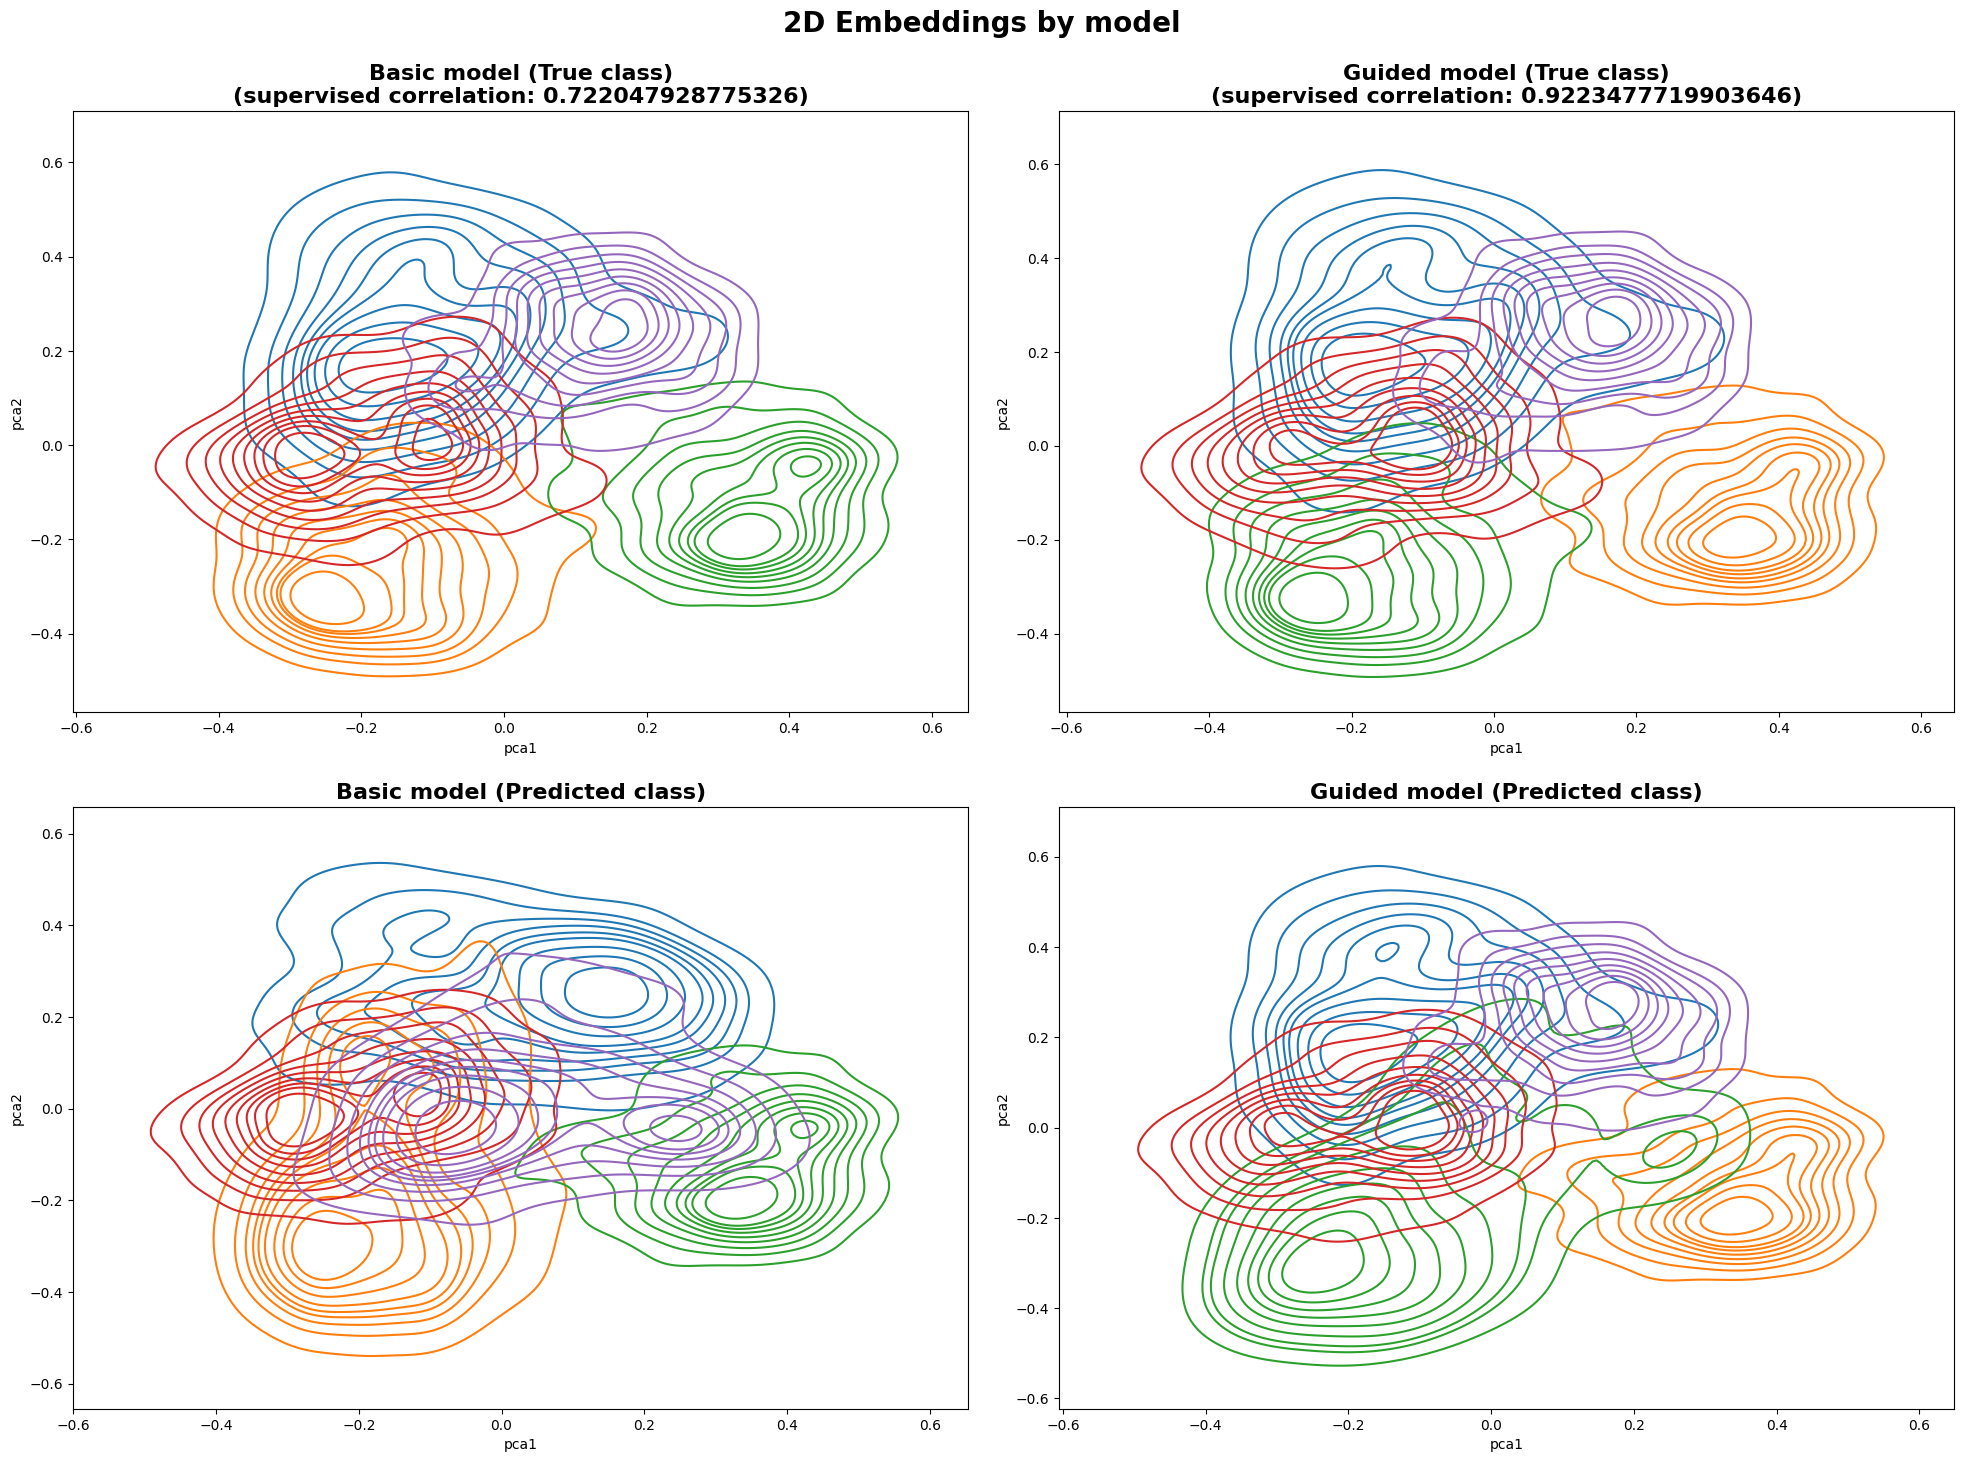

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('2D Embeddings by model', fontsize=20, fontweight='bold')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

x, y = 0, 0

for j, y_type in enumerate(['y_true', 'y_pred']):
    part_title = 'True class' if y_type == 'y_true' else 'Predicted class'

    # -- Basic model
    for i, class_name in enumerate(basic_relevant_results_df[y_type].unique()):
        indices = basic_relevant_results_df[y_type] == class_name
        sns.kdeplot(data=basic_relevant_results_df[indices], x="pca1", y="pca2", ax=ax[x, y], label=class_name, color=colors[i])

    title = f'Basic model ({part_title})'
    if j == 0:
        title += f'\n(supervised correlation: {basic_supervised_correlation})'
    ax[x, y].set_title(title, fontsize=16, fontweight='bold')

    y += 1

    # -- Guided model
    for i, class_name in enumerate(guided_relevant_results_df[y_type].unique()):
        indices = guided_relevant_results_df[y_type] == class_name
        sns.kdeplot(data=guided_relevant_results_df[indices], x="pca1", y="pca2", ax=ax[x, y], label=class_name, color=colors[i])

    title = f'Guided model ({part_title})'
    if j == 0:
        title += f'\n(supervised correlation: {guided_supervised_correlation})'
    ax[x, y].set_title(title, fontsize=16, fontweight='bold')

    y = 0
    x += 1

fig.tight_layout(pad=2.0)
fig.savefig('../../figures/guided_bertopic/2d_embeddings_by_model.png')